In [1]:
import cv2
import sys
import os
import random
import copy
from  time import perf_counter
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy import signal
from skimage import morphology
import similaritymeasures

In [2]:
#悬链线方程，需要拟合a,b,c三个参数
def function(x, a, b, c):
    if (abs(a - 0) < 1e-12):
        return c
    result = a * np.cosh((x-b)/a) + c
    return result

In [3]:
def Skeleton_extraction(Image_origin):
    Image_origin = cv2.cvtColor(Image_origin,cv2.COLOR_BGR2GRAY)
    _,Image_origin = cv2.threshold(Image_origin,100, 255, cv2.THRESH_BINARY)  # 二值化处理

    Image_origin[Image_origin==255] = 1
    [image_y_max,image_x_max] = Image_origin.shape
    ys, xs = np.where(Image_origin != 0)
    min_x, max_x = np.min(xs), np.max(xs)
    min_y, max_y = np.min(ys), np.max(ys)
    # min_x = max_x = min_y = max_y = 0
    # sum_col = np.sum(Image_origin,axis=0)
    # for i in range(1,image_x_max):
    #     if (sum_col[i] != 0):
    #         min_x = i - 1
    #         break
    # for i in range(image_x_max-2,min_x,-1):
    #     if (sum_col[i] != 0):
    #         max_x = i + 1
    #         break


    # sum_row = np.sum(Image_origin,axis=1)
    # for i in range(1,image_y_max):   
    #     if (sum_row[i] != 0):
    #         min_y = i - 1
    #         break
    # for i in range(image_y_max - 2,min_y,-1):
    #     if (sum_row[i] != 0):
    #         max_y = i + 1
    #         break

    Image_cut = Image_origin[min_y:max_y,min_x:max_x]
    
    skeleton0 = morphology.skeletonize(Image_cut)   # 骨架提取
     # 中轴骨架化：效果不好，骨架太尖锐了
    # skel, distance = medial_axis(Image_cut, return_distance=True)
    # Image_skeleton = distance * skel
    
    skeleton = skeleton0.astype(np.uint8)
    # plt.imshow(skeleton,cmap="gray")
    # plt.show()
    return Image_cut,skeleton


In [4]:
def randomcolor():
    colorArr = ['1','2','3','4','5','6','7','8','9','A','B','C','D','E','F']
    color = ""
    for i in range(6):
        color += colorArr[random.randint(0,14)]
    return "#"+color


In [5]:
def show_fitted_curve(Image,parameter):
    [image_y_max,image_x_max] = Image.shape
    print("拟合结果展示：\n")
    plt.xlim((0, image_x_max-1))
    plt.ylim((image_y_max-1, 0))
    plt.axis('off')
    plt.imshow(Image,cmap = "gray")
    for label in list(parameter.keys()):
        t = parameter[label]
        x_fit = np.zeros(image_x_max)
        y_fit = np.zeros(image_x_max)
        for x in range(0,image_x_max):
            x_fit[x] = x
            y_fit[x] = function(x,t[0],t[1],t[2])
        u_fit = - y_fit + image_y_max - 1
        
        plt.plot(x_fit,u_fit,color = randomcolor(),linewidth = 2)
    plt.show()

In [6]:
#保存拟合结果图片
def save_fitted_png(Image,parameter,file_path,file_name):
    [image_y_max,image_x_max] = Image.shape
    print("拟合结果展示：\n")
    plt.xlim((0, image_x_max-1))
    plt.ylim((image_y_max-1, 0))
    plt.axis('off')
    plt.imshow(Image,cmap = "gray")
    for label in list(parameter.keys()):
        t = parameter[label]
        x_fit = np.zeros(image_x_max)
        y_fit = np.zeros(image_x_max)
        for x in range(0,image_x_max):
            x_fit[x] = x
            y_fit[x] = function(x,t[0],t[1],t[2])
        u_fit = - y_fit + image_y_max - 1
        plt.plot(x_fit,u_fit,color = randomcolor(),linewidth = 2)
    file = file_path + "fit\\" + file_name + "_fit" + ".png"
    plt.savefig(file,dpi=1080,bbox_inches='tight', pad_inches=0)
    plt.show()

In [7]:
#对于属于一簇的样本点，计算弯曲度
def calculate_radian(sample_points):
    #sample_points = sorted(sample_points, key=lambda x: x[0])  # 按x升序排列  
    radian = 0           
    #取出样本点的起点和终点，画出直线。
    start = sample_points[0]
    end = sample_points[-1]
    x_start,y_start = start[0],start[1]
    x_end,y_end = end[0],end[1]
    #横线或竖线     
    if ((x_start == x_end) or (y_start == y_end)):
        return 0 
      
    #斜率k不为0或无穷时。
    k = (y_end - y_start) / (x_end - x_start)
    b = y_end - k * x_end
            
    #计算曲线到直线的距离，取出最大值计算弯曲度
    line_length  = np.sqrt(pow(x_end - x_start,2) + pow(y_end - y_start,2))
    distances = []
    denominator = np.sqrt(1+k*k)
    for point in sample_points:
        distance = abs(k*point[0] - point[1] + b) / denominator
        distances.append(distance)

    max_distance = np.max(distances)
    radian = max_distance / line_length 

    return radian

In [8]:
# def divide_into_k_groups(n, k):
#     assert(n >= k)
#     def helper(start, groups):
#         if start > n:
#             if all(len(group) > 0 for group in groups):
#                 return [groups]
#             else:
#                 return []
#         res = []
#         for i in range(k):
#             if start in groups[i]:
#                 continue
#             new_groups = [group[:] for group in groups]
#             new_groups[i].append(start)
#             res += helper(start+1, new_groups)
#         return res
#     res = helper(1, [[] for _ in range(k)])
#     for part in res:
#         part.sort(key = lambda x:x[0])
        
#     new_res=[]
#     for i in res:
#         if i not in new_res:
#             new_res.append(i)
#     return new_res

In [9]:
#当n比较大时，将n个元素分为k组，这个运算十分耗时，建议存储一个表格，只要运算一次，
# 而不是每次都要重新生成。根据目前情况，存储n<=10的情况基本足够
#BUG:某些分组无法生成，请使用divide_into_k_groups()函数
# def merge_two_group(all_k_groups):
#     out_num = len(all_k_groups)
#     #print("分组K的情况数:",out_num)
#     k_add_1_groups = []
#     for i in range(0,out_num):
#         k_groups = all_k_groups[i]
#         #print(k_groups)
#         in_num = len(k_groups)
#         if(in_num <= 1):
#             k_add_1_groups = all_k_groups
#             break
        
#         for j in range(0,in_num):
#             for k in range(j+1,in_num):
#                 res_group = copy.deepcopy(k_groups)
#                 j_end = res_group[j][-1]
#                 j_len = len(res_group[j])
#                 k_start = res_group[k][0]
#                 k_len= len(res_group[k])
#                 #对于[1,4]和[3],不合并。对于[1,3]和[4]，合并
#                 #对于[1,2]和[3]，合并，对于[1]和[2,3]，不合并
#                 if (j_end > k_start or j_len < k_len):
#                     continue
#                 for label in res_group[k]:
#                     res_group[j].append(label)
#                 del res_group[k]
                
#                 #print("res_group:",res_group)  
#                 k_add_1_groups.append(res_group)
    
#     for group in k_add_1_groups:
#         group.sort(key = lambda x:x[0])
        
#     unique_groups=[]
#     for group in k_add_1_groups:
#         if group not in unique_groups:
#             unique_groups.append(group)
#     return unique_groups
                


In [10]:
# n_divide_k_groups = {}
# for i in range(1,11):
#     initial_groups = [[[k] for k in range(1,i+1)]]
#     n_divide_k_groups[(i,i)] = initial_groups
#     for j in range(1,i):
#         new_groups = merge_two_group(initial_groups)
#         initial_groups = new_groups
#         n_divide_k_groups[(i,i-j)] = initial_groups
# print(n_divide_k_groups)

In [11]:
# 嵌套数字列表
#nested_list = [[[1],[2],[3]], [[1, 2], [3]], [[1, 2, 3]]]

# 写入txt文件
# def save_n_k_groups(n,k,file_path):
#     res_list = divide_into_k_groups(n,k)
#     filename = str(n) + '-' + str(k) + '.txt'
#     file = file_path + "groups\\" + filename
#     with open(file, 'w') as f:
#         for sublist in res_list:
#             parts = []
#             for subsublist in sublist:
#                 level1 = [str(item) for item in subsublist]
#                 part = ','.join(level1)
#                 parts.append(part)    
#             line = ';'.join(parts)
#             f.write(line + '\n')
#     return res_list

In [12]:
# 从txt文件读取嵌套数字列表
# def get_n_k_groups(n,k,file_path):
#     filename = str(n) + '-' + str(k) + '.txt'
#     file = file_path + "\\groups\\" + filename
#     if os.path.exists(file):
#         nested_list = []
#         with open(file, 'r') as f:
#             lines = f.readlines()

#             for line in lines:
#                 str_linelist = [item for item in line.strip().split(';')]
#                 #print("linelist:\n",str_linelist)
#                 int_linelist = []
#                 for part in str_linelist:
#                     int_partlist = [int(item) for item in part.split(',')]
#                     #print("partlist:\n",int_partlist)
#                     int_linelist.append(int_partlist)
#                 nested_list.append(int_linelist)
#             #print(nested_list)
#         return nested_list    
#     else :
#         print(str(n)+ '-' + str(k) + "文件不存在,正在生成中")
#         #生成并保存到文件中
#         return save_n_k_groups(n,k,file_path)
        

In [13]:
# class FullClustering:
#     def __init__(self,data,Image):
#         self.data = data
#         self.Image = Image
#         [self.image_y_max,self.image_x_max] = Image.shape
#         self.interval_endpoints = {}
#         for label in data:
#             x_start = data[label][0][0]
#             x_end = data[label][-1][0]
#             self.interval_endpoints[label] = [x_start,x_end]
            
#     def compute_error(self,clusters):
#         level_error = 0
#         level_parameter = np.zeros((len(clusters),3))
#         for i in range(0,len(clusters)):
#             cluster_error = self.image_x_max
#             sample_points = np.zeros((0,2))
            
#             for label in clusters[i]:
#                 sample_points = np.concatenate((sample_points,self.data[label]),axis=0)
#             parameter_initial = [self.image_y_max,self.image_x_max,-self.image_y_max]
#             try:
#                 parameter,_ = curve_fit(function,sample_points[:,0],sample_points[:,1],p0 = parameter_initial,method = 'dogbox',max_nfev=10000)    
#             except RuntimeError:
#                 parameter = [0,0,0]
#             level_parameter[i,:] = parameter
            
#             for point in sample_points:
#                 x = point[0]
#                 y = point[1]
#                 predict = function(x,parameter[0],parameter[1],parameter[2])
#                 if abs(predict-y) <= 3:
#                     cluster_error = cluster_error - 1
            
#             level_error = level_error + cluster_error
#         level_error = level_error/len(clusters)
#         return level_error,level_parameter
           
#     def select_k_clustering(self,groups):
        
#         level_error = []
#         level_parameter = []
#         # 对于不合理的分簇结果，直接去除，不参与拟合
#         j = 0
#         while j < len(groups):
#             group = groups[j]
#             is_rational = True
#             for cluster in group:
#                 intervals = []
#                 for label in cluster:
#                     res = self.interval_endpoints[label]
#                     intervals.append(res)
#                 intervals = sorted(intervals, key=lambda x: x[0])  # 按x升序排列
#                 # print(intervals)
#                 for i in range(0,len(intervals)-1):
#                     x1_end = intervals[i][1]
#                     x2_start = intervals[i+1][0]
#                     if x1_end > x2_start+3:
#                         is_rational = False
#                         break
#                 if (not is_rational):
#                     break
#             if (not is_rational):
#                 del groups[j]
#             else :
#                 j += 1     
        
#         for group in groups:
#             error,parameter = self.compute_error(group)
#             level_error.append(error)
#             level_parameter.append(parameter)
#         return groups,level_error,level_parameter
    
#     def full_clustering(self,file_path):
#         num = len(self.data)
#         #initial_groups = [[[label] for label in list(self.data)]]
#         res_err = sys.maxsize
#         res_clusters = []
#         res_parameter = []
#         for k in range(0,num):
#             #在此处挑选合理的groups
#             initial_groups = get_n_k_groups(num,k+1,file_path)
#             clusters,error,parameter = self.select_k_clustering(initial_groups)
#             # 如果k分簇结果都是不合理的，无法进行index = np.argmin(error)操作  
#             if (not clusters):
#                 continue
#             index = np.argmin(error)
#             if (res_err > error[index]) :
#                 res_err = error[index]
#                 res_clusters = clusters[index]
#                 res_parameter = parameter[index]
#             #initial_groups =  merge_two_group(clusters)
        
#         return res_clusters,res_parameter
        

In [14]:
def estimate_parameter_bounds(start,end):
    x1,y1 = start
    x2,y2 = end
    L = np.sqrt(pow(x2-x1,2)+ pow(y2-y1,2))
    D = abs(x2 - x1)
    a_min = pow(D,2) / (4 * L) 
    a_max = L / 2
    b_min = min(x1,x2)
    b_max = max(x1,x2)
    c_min = min(y1,y2) - a_max
    c_max = max(y1,y2)
    lower_bound = [a_min,b_min,c_min]
    upper_bound = [a_max,b_max,c_max]
    return (lower_bound,upper_bound)

In [15]:
endpoints = {}
start = [1,2]
end = [3,4]
endpoints[1] = [start,end]
start1,end1 = endpoints[1]
print(start1)
print(end1)

[1, 2]
[3, 4]


In [16]:
class HierarchicalClustering:
    def __init__(self,data,parameter,Image):
        self.data = data
        self.parameter = parameter 
        self.Image = Image
        [self.image_y_max,self.image_x_max] = Image.shape
        self.interval_endpoints = {}
        for label in list(self.data.keys()):
            start = self.data[label][0]
            end = self.data[label][-1]
            self.interval_endpoints[label] = [start,end]

    #计算两簇样本点的拟合距离
    def compute_distance(self,label1,label2):
        parameter1 = self.parameter[label1]
        sample_points2 = self.data[label2]
        num_points = len(sample_points2)
        
        sample_points1 = np.zeros((num_points,2))
        sample_points1[:,0] = sample_points2[:,0]
        for i in range(0,num_points):
            x = sample_points2[i][0]
            sample_points1[i,1] = function(x,parameter1[0],parameter1[1],parameter1[2])
        
        # quantify the difference between the two curves using PCM
        #pcm = similaritymeasures.pcm(sample_points1, sample_points2,norm_seg_length=True)
        # quantify the difference between the two curves using
        # Discrete Frechet distance
        #df = similaritymeasures.frechet_dist(sample_points1, sample_points2)

        # quantify the difference between the two curves using
        # area between two curves
        #area = similaritymeasures.area_between_two_curves(sample_points1, sample_points2)
        #area = area /num_points
        # quantify the difference between the two curves using
        # Curve Length based similarity measure
        #cl = similaritymeasures.curve_length_measure(sample_points1, sample_points2)

        # quantify the difference between the two curves using
        # Dynamic Time Warping distance
        # dtw, d = similaritymeasures.dtw(sample_points1, sample_points2)
        # dtw = dtw / num_points
        
        # mean absolute error
        #mae = similaritymeasures.mae(sample_points1, sample_points2)

        # mean squared error
        #mse = similaritymeasures.mse(sample_points1, sample_points2)
        
        #return area
        
        sum_error = 0
        num_points = len(sample_points2)
        for i in range(0,num_points):
            x = sample_points2[i][0]
            y = sample_points2[i][1]
            sum_error = sum_error + pow(function(x,parameter1[0],parameter1[1],parameter1[2]) - y,2)
        mean_error = 1.0*sum_error/num_points 
        return min(mean_error,sys.maxsize)   
   
    #根据给定的数据集，创建一个距离矩阵。
    def create_distance_matrix(self):
        dlabels = list(self.data.keys())
        plabels = list(self.parameter.keys())
        assert(dlabels == plabels)
        max_label = max(dlabels)
        dist_matrix = np.full((max_label+1,max_label+1),sys.maxsize)
        for label1 in dlabels:
            start1,end1 = self.interval_endpoints[label1]
            x1_start,x1_end = start1[0],end1[0]
            for label2 in dlabels:
                if (label2 == label1):
                    continue
                start2,end2 = self.interval_endpoints[label2]
                x2_start,x2_end = start2[0],end2[0]
                if ((x2_start < x1_start < x2_end) or (x1_start < x2_start < x1_end)):
                    continue
                
                dist_matrix[label1][label2] = self.compute_distance(label1,label2)
        return dist_matrix

    def merge_clusters(self,label1,label2):
        #TODO:合并data[i]、data[j]
        if (label1 == label2):
            return
        
        new_sample_points = np.concatenate((self.data[label1],self.data[label2]),axis=0)
        self.data[label1] = np.array(sorted(new_sample_points, key=lambda x: x[0])) # 按x升序排列  
        del self.data[label2]

        #interval_endpoints也要更新
        start = self.data[label1][0]
        end = self.data[label1][-1]
        self.interval_endpoints[label1] = [start,end]
        del self.interval_endpoints[label2]
        
        
        #增加参数范围估计
        #参数范围不好估计，去除此步
        start,end = self.interval_endpoints[label1]
        parameter_initial = [self.image_y_max,self.image_x_max,self.image_y_max]
        #parameter_bounds = estimate_parameter_bounds(start,end)
        try:
            #parameter,_ = curve_fit(function,points[:,0],points[:,1],method = 'dogbox',max_nfev=1000)
            parameter,_,infodict,message,_ =curve_fit(function,new_sample_points[:,0],new_sample_points[:,1],p0 = parameter_initial,
                                                      method = 'lm',maxfev=5000,
                                                      full_output=True)
            print("参数拟合步数为:",infodict["nfev"])
            #print("拟合信息为:",message)
        except RuntimeError:
            print("参数拟合步数超过设定,参数将被设为0.\n")
            parameter = [0,0,0]
        
        self.parameter[label1] = parameter
        del self.parameter[label2]
        
    def update_distance(self,dist_matrix,label1,label2):
        labels = list(self.data.keys())
        dist_matrix[label2].fill(sys.maxsize)
        dist_matrix[:,label2].fill(sys.maxsize) 
        dist_matrix[label1].fill(sys.maxsize)
        dist_matrix[:,label1].fill(sys.maxsize)
        for label in labels:
            if (label == label1):
                continue
            
            interval1 = [endpoint[0]  for endpoint in self.interval_endpoints[label1]]
            interval = [endpoint[0]  for endpoint in self.interval_endpoints[label]]
            endpoints = [interval1,interval]
            endpoints = sorted(endpoints, key=lambda x: x[0])  # 按x升序排列  
            #BUG:这里会遗漏一些情况，比如三个片段，两端连接，而中间未连接 
            #FIXed
            if (endpoints[1][1] > endpoints[0][1] > endpoints[1][0]):
                continue    
            
            dist_matrix[label1][label] = self.compute_distance(label1,label)
            dist_matrix[label][label1] = self.compute_distance(label,label1)
        return dist_matrix
    
    def find_closest_clusters(self,dist_matrix):
        min_distance = np.min(dist_matrix)
        indexs = np.where(dist_matrix==min_distance)
        # i < j
        i = min(indexs[0][0],indexs[1][0])
        j = max(indexs[0][0],indexs[1][0])
        return i,j,min_distance
            
    def hierarchical_clustering(self,distance):
        if(len(self.data) <= 1) :
            return self.data,self.parameter
        # 创建距离矩阵
        start = perf_counter()
        dist_matrix = self.create_distance_matrix()
        end = perf_counter()
        print(f"距离矩阵大小：{len(self.data)},创建距离矩阵时间：{end-start}s")
        # 循环合并簇，直到没有满足合并条件的簇
        
        while True:    
            # 找到距离最近的簇
            label1, label2, min_distance = self.find_closest_clusters(dist_matrix)
            #是否满足合并条件
            if (min_distance < distance):
                start  = perf_counter()
                #print("簇间距:",min_distance)
                self.merge_clusters(label1, label2)
                # 更新距离矩阵
                dist_matrix = self.update_distance(dist_matrix,label1,label2)
                end = perf_counter()
                print(f"合并第{label1}簇和第{label2}簇时间：{end-start}秒")
            else:
                #没有可以合并的簇
                break

        return self.data,self.parameter
        
                


In [17]:
# for root, ds, fs in os.walk(".\\new_mask"):
#     for f in fs:
#         if f.endswith('.png'):
#             fullname = os.path.join(root, f)
#             f_new = f.replace(" ","")
#             os.rename(os.path.join(root,f),os.path.join(root,f_new))
            

In [18]:
def crop_connected_components(img):
    # 寻找连通区域
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=8)
    
    # 获取小图片列表和小图片左上角顶点在原图片的位置
    imgs = []
    positions = []
    size = []
    for i in range(1, num_labels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        # 将小图片中的其他标签涂成背景色
        img_copy = np.zeros((h, w), dtype=np.uint8)
        img_copy[labels[y:y+h, x:x+w] == i] = 1
        imgs.append(img_copy)
        positions.append((x, y))
        size.append((w,h))
    return imgs, positions,size

In [19]:
def preprocess_image(Image):
    #先进行膨胀、腐蚀
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(4,4))
    dilate = cv2.dilate(Image, kernel, iterations=2) #膨胀，使图像变粗：增强连接，填充凹痕 
    Image = cv2.erode(dilate, kernel, iterations=2) # 腐蚀，使图像变细
     
    # 再进行骨架提取
    Image_cut,skeleton = Skeleton_extraction(Image)
    [image_y_max,image_x_max] = skeleton.shape
    size = max(image_x_max,image_y_max)
    #第一次移除段片段
    Image_skeleton = np.array(skeleton, dtype = bool)
    Image_skeleton = morphology.remove_small_objects(Image_skeleton,min_size=size/10,connectivity=2)
    Image_clean = Image_skeleton.astype(np.uint8)
    
    # 断裂交点
    neighbour_matrix = signal.convolve2d(Image_clean, np.ones((3, 3)), mode='same')
    cross_points = np.where(neighbour_matrix>3)
    #print("cross_point:\n",cross_points)
    dxs = np.arange(-3,4,1)
    dys = dxs
    for i in range(0,len(cross_points[0])):
        y = cross_points[0][i]
        x = cross_points[1][i]
        for dx in dxs:
            for dy in dys:
                if (0 <= y+dy < image_y_max and 0 <= x+dx < image_x_max):
                    Image_clean[y+dy,x+dx] = 0
    Image_clean[neighbour_matrix>3] = 0 
    
    # 对断裂后的图片再次移除短片段
    Image_bool = np.array(Image_clean, dtype = bool)
    Image_clean = morphology.remove_small_objects(Image_bool,min_size=size/20,connectivity=2)
    Image_clean = Image_clean.astype(np.uint8)
    
    return Image_cut,Image_clean 

In [20]:
def get_samples_and_parameters(Image,distance):
    [image_y_max,image_x_max] = Image.shape
    num_labels, labels, _, _ = cv2.connectedComponentsWithStats(Image)
    #print("区域数:%d\n" %(num_labels-1))
    points_per_label = {}
    parameters_per_label = {}
    for label in range(1,num_labels):
        # 创建一个布尔掩码来选择当前标签下的所有像素
        mask = (labels == label)
        # 使用掩码选择当前标签下的所有像素，并将它们转换为(y,x)坐标对列表
        points = np.argwhere(mask) 
        points = [(x,-y+image_y_max-1) for y, x in points] 
        points = np.array(sorted(points, key=lambda x: x[0]))  # 按x升序排列   
        points_per_label[label] = points
        #初始参数， If None, then the initial values will all be 1
        parameter_initial = [image_y_max,image_x_max,-image_y_max]
        #试图利用端点信息对参数进行一个预估范围
        #失效，不好估计，容易导致曲线弯曲度很大
         #parameter_bounds = estimate_parameter_bounds(points[0],points[-1])
        
        start = perf_counter()
        try:
            #parameter,_ = curve_fit(function,points[:,0],points[:,1],method = 'dogbox',max_nfev=1000)
            parameter,_,infodict,message,_ =curve_fit(function,points[:,0],points[:,1],p0 = parameter_initial,
                                                      method = 'lm',maxfev=5000,
                                                      full_output=True)
            print("参数拟合步数为:",infodict["nfev"])
            #print("拟合信息为:",message)
        except RuntimeError:
            print("参数拟合步数超过设定,参数将被设为0.\n")
            parameter = [0,0,0]
        end = perf_counter()
        print(f"拟合第{label}个片段：耗时{end-start}秒\n")
        
        #绘制用到的样本点
        # print(f"第{label}个片段的样本点\n")
        # plt.xlim((0, image_x_max-1))
        # plt.ylim((image_y_max-1, 0))
        # plt.imshow(Image,cmap = "gray")          
        # plt.plot(points[:,0],- points[:,1] + image_y_max - 1,color = randomcolor(),linewidth = 2)
        # plt.show()    
        parameters_per_label[label] = parameter
    
    start = perf_counter()
    cluster = HierarchicalClustering(points_per_label,parameters_per_label,Image)
    res_sample_points,res_parameters = cluster.hierarchical_clustering(distance)
    end = perf_counter()
    print(f"层次聚类时间：{end-start}")
    
    return res_sample_points,res_parameters

In [21]:
def caternary_fit(file_path,f,file_ext,distance):
    print(file_path + f + file_ext + "\n")
    file = file_path + f + file_ext
    Image_origin = cv2.imread(file)
    
    #图片预处理
    start = perf_counter()
    Image_cut,Image_clean = preprocess_image(Image_origin)
    [image_y_max,image_x_max] = Image_cut.shape
    end = perf_counter()
    print(f"图片预处理时间：{end-start}秒")
 
    plt.imshow(Image_cut,cmap ="gray")
    plt.show()    
    plt.imshow(Image_clean,cmap ="gray")
    plt.show()
    
    #将Image_cut保存到\cut子文件夹下
    # start = perf_counter()
    # plt.xlim((0, image_x_max-1))
    # plt.ylim((image_y_max-1, 0))
    # plt.axis('off')
    # plt.imshow(Image_cut,cmap = "gray")
    # cut_file = file_path + "cut\\" + f + "_cut" + file_ext
    # plt.savefig(cut_file,dpi=1080,bbox_inches='tight', pad_inches=0)
    # plt.show() 
    # end = perf_counter()
    # print("保存cut时间:",end-start)
    
    #聚类、拟合，返回样本点和拟合参数的字典，每个label对应一个拟合结果
    start = perf_counter()
    res_sample_points,res_parameters = get_samples_and_parameters(Image_clean,distance)
    end = perf_counter()
    print(f"get_samples_and_parameters时间:{end-start}秒")
    
    #展示拟合用到的样本点，检查是否在全局处于正确的位置。以及对应拟合得到的曲线。
    print("拟合样本点及对应的拟合结果：\n")
    start = perf_counter()
    for label in  res_sample_points:
        print("label:\n",label)
        print("parameter:",res_parameters[label])
        sample_points = np.array(res_sample_points[label]) 
        plt.xlim((0, image_x_max-1))
        plt.ylim((image_y_max-1, 0))
        plt.imshow(Image_cut,cmap = "gray")          
        plt.plot(sample_points[:,0],- sample_points[:,1] + image_y_max - 1,color = randomcolor(),linewidth = 2)
        plt.show()   
        # res = {}
        # res[1] = res_parameters[label]
        # show_fitted_curve(Image_clean,res)      
    end = perf_counter()
    print("展示拟合样本点及对应的拟合结果时间:",end-start)
    
    #将拟合的曲线图片保存到\fit文件夹下，后缀为_fit
    show_fitted_curve(Image_cut,res_parameters)
    # start = perf_counter()
    # save_fitted_png(Image_cut,res_parameters,file_path,f)
    # end = perf_counter()
    # print("保存fit图片时间:",end-start)
    
    # 把使用的样本点分类保存到\fit文件夹下，后缀为_sample
    # start = perf_counter()
    # plt.xlim((0, image_x_max-1))
    # plt.ylim((image_y_max-1, 0))
    # plt.imshow(Image_cut,cmap = "gray")
    # plt.axis('off')
    # print("拟合样本点：\n")
    # for label in res_sample_points:
    #     sample_points = np.array(res_sample_points[label])          
    #     plt.plot(sample_points[:,0],-sample_points[:,1] + image_y_max - 1,color = randomcolor(),linewidth = 2)
    # fit_file = file_path + "fit\\"+ f + "_sample" + file_ext
    # plt.savefig(fit_file,dpi=1080,bbox_inches='tight', pad_inches=0)
    # plt.show()  
        
    # end = perf_counter()
    # print("保存图片sample时间:",end-start)
    
    # #将参数和弯曲度保存到文件中
    # start = perf_counter()
    # radians = {}
    # parameter_file = file_path + "parameter\\" + f +"_parameter.txt"
    # f = open(parameter_file, 'w',encoding='UTF-8')
    # # 设置格式tplt，10代表间隔距离，可根据自己需要调整
    # tplt = "{:<10}\t{:<10}\t{:<10}\t{:10}"
    # # 按tplt格式写入抬头行
    # f.write(tplt.format('parameter - a', ' parameter - b', 'parameter - c', 'radian', chr(255)))
    # f.write('\n')
    # for label in res_sample_points:
    #     #保留小数点后n位,round(a, n)
    #     sample_points = res_sample_points[label]  
    #     radian = calculate_radian(sample_points)
    #     radians[label] = radian
    #     parameter = res_parameters[label]
    #     f.write(tplt.format('%.10g'%parameter[0],'%.10g'%parameter[1],'%.10g'%parameter[2],'%.10g'%radian,chr(255)))
    #     f.write('\n')
    # f.close()
    # end = perf_counter()
    # print("保存参数和弯曲度时间:",end-start)
    
    for label in res_sample_points:
        sample_points = res_sample_points[label]  
        radian = calculate_radian(sample_points)
        parameter = res_parameters[label]
        print("曲线id:",label)
        print("参数：",parameter)
        print("弯曲度：",radian)


.\ForSRTP\25.png

图片预处理时间：0.04430460010189563秒


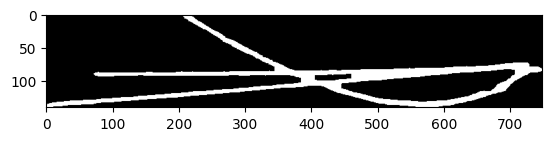

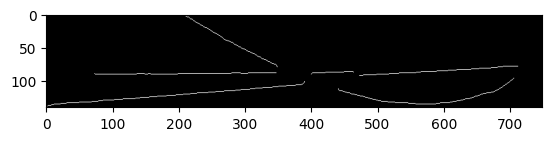

参数拟合步数为: 45
拟合第1个片段：耗时0.0011193000245839357秒

参数拟合步数为: 59
拟合第2个片段：耗时0.0010038999607786536秒

参数拟合步数为: 103
拟合第3个片段：耗时0.0010730000212788582秒

参数拟合步数为: 69
拟合第4个片段：耗时0.0010520999785512686秒

参数拟合步数为: 29
拟合第5个片段：耗时0.0005177999846637249秒

参数拟合步数为: 77
拟合第6个片段：耗时0.0013473000144585967秒

距离矩阵大小：6,创建距离矩阵时间：0.022288599982857704s
参数拟合步数为: 92
合并第3簇和第4簇时间：0.007048600004054606秒
参数拟合步数为: 106
合并第2簇和第6簇时间：0.015794799895957112秒
层次聚类时间：0.0453959999140352
get_samples_and_parameters时间:0.05618829990271479秒
拟合样本点及对应的拟合结果：

label:
 1
parameter: [ 1036.12992328   818.2654868  -1082.47247157]


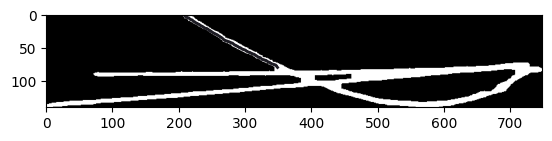

label:
 2
parameter: [ 166384.01026273  -14236.5648564  -166992.04031218]


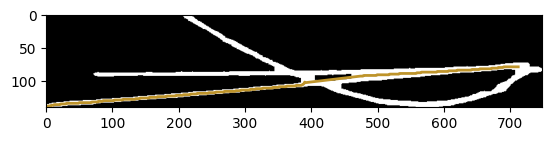

label:
 3
parameter: [ 41044.97958555    -96.69055821 -40996.42315853]


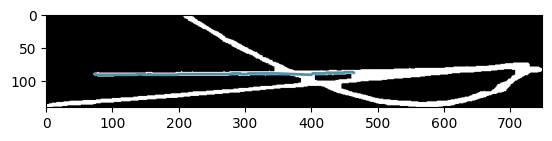

label:
 5
parameter: [ 312.61935168  561.22623639 -308.88429062]


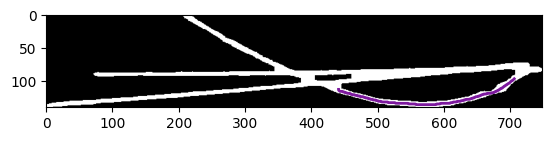

展示拟合样本点及对应的拟合结果时间: 0.418725399998948
拟合结果展示：



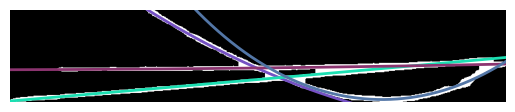

曲线id: 1
参数： [ 1036.12992328   818.2654868  -1082.47247157]
弯曲度： 0.01825742574257423
曲线id: 2
参数： [ 166384.01026273  -14236.5648564  -166992.04031218]
弯曲度： 0.0093559188497144
曲线id: 3
参数： [ 41044.97958555    -96.69055821 -40996.42315853]
弯曲度： 0.006835202930307097
曲线id: 5
参数： [ 312.61935168  561.22623639 -308.88429062]
弯曲度： 0.1198479022715342


In [22]:
#图像分割与拼装
file_path = ".\\ForSRTP\\"
file_name = [str(f)  for f in range(25,26)]
file_ext = ".png"
for f in file_name:
    caternary_fit(file_path,f,file_ext,distance = 490)